# Chatbot con Red Neuronal Sequential (Keras)

Librerías necesarias:

In [1]:
## Librerías:
# ... Para 'intents.json'
import json # Para el formato json
import codecs # Lectura de caracteres en español (tildes y 'ñ')
# ... Procesamiento de Lenguaje Natural
import spacy # Lemmatizer (convertir palabras) con lenguaje español
import pickle # Guardar archivos
import numpy as np 
import nltk # Natural Language ToolKit: Tokenizar
from recursos import lemmatizer, normalize_tilde

Para crear la Red Neuronal Secuencial con Keras:

In [2]:
# Redes Neuronales:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

## A. Entrenamiento

### A.1. Extraer palabras y tags de 'intents.json'

El siguiente extracto se encuentra en el archivo de entrenamiento regular 'training.py'

In [3]:
## 1. Cargar la información del archivo json

def load_training_data(json_file = "intents.json"):
    # Cargar archivo json:
    intents = json.loads(codecs.open(json_file, encoding='utf-8').read())
    
    words = [] # Palabras individuales usadas
    tags = [] # Etiquetas de intención
    ignore_letters = ['¿', '?', '.', ',', ';', '¡', '!', '(', ')']
    documents = [] # Lista de tuplas ([Lista de palabras], etiqueta asociada de intención)
    for intent in intents['intents']:
        # Por cada intención:
        for pattern in intent['patterns']:
            # Tokenizar el patrón de palabras que usaría el usuario y agregar las palabras a 'words'.
            pattern = lemmatizer(pattern) #........ Para separar '¿__w1__w2' y pasar palabras a su forma base.
            pattern = normalize_tilde(pattern) #... Quitas las tildes.
            word_list = nltk.word_tokenize(pattern)
            words.extend(word_list)
            # Agregar a 'documents' la tupla (lista de palabras, etiqueta de la intención)
            documents.append((word_list, intent['tag']))
            if intent['tag'] not in tags:
                tags.append(intent['tag'])
            # Fin del segundo bucle
        # Fin del primer bucle
    words = [lemmatizer(word.lower()) for word in words if word not in ignore_letters]
    words = sorted(set(words))
    tags = sorted(set(tags))
    """
    Ejemplo:
    - words = ['Buen', 'Hola', 'día', ...]
    - tags = ['saludos', 'opciones', 'consulta_lugar']
    - documents = [(['Buen', 'día'], 'saludos'), (['Hola'], 'saludos'), ([...], 'opciones'), ...]
    """
    return words, tags, documents

words, tags, documents = load_training_data()
print("intents.json cargado")
print("Palabras detectadas:", len(words))
print("Intenciones detectadas:", len(tags))

# ... Guardarlos
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(tags, open('tags.pkl', 'wb'))
# ... 'documents' ayudará a crear la matriz de entrenamiento

intents.json cargado
Palabras detectadas: 138
Intenciones detectadas: 13


Luego, se transforman las oraciones (en el arreglo 'documents') a su representación bag of words (según el arreglo 'words') 

In [4]:
# 2. Bag of Words: Formar matriz Training 

training = []
output_empty = [0] * len(tags)

for document in documents:
    # Por cada tupla ([consulta de palabras], tag)
    bag = [] # ... bag of words
    word_patterns = document[0] #... lista de palabras
    word_patterns = [lemmatizer(word.lower()) for word in word_patterns] #... lematizar las palabras en minúsculas
    for word in words:
        # Por cada palabra en el conjunto total de palabras encontradas en el archivo json.
        bag.append(1) if word.lower() in word_patterns else bag.append(0)
        # Si dicha palabra está entre el patrón de este documento: 1; else -> 0
    # - bag = [0,0,0,...,1], de len(bag) = len(words)
    
    output_row = list(output_empty) # Hacer una lista de 0, del tamaño de len(tags)
    output_row[tags.index(document[1])] = 1 # Cambia a '1' la celda de mismo índice que tag en tags.
    training.append([bag, output_row]) # Se agrega a la matriz de Training.

random.shuffle(training) # Mezclar Data de Entrenamiento
training = np.array(training)
print("Formada matriz training. Filas: %s, Etiquetas:%s)"%(len(training), len(training[0][1])))

train_x = list(training[:,0]) # Entradas
train_y = list(training[:,1]) # Salidas

Formada matriz training. Filas: 170, Etiquetas:13)


### A.2. Entrenar modelos de Red Neuronal

In [5]:
models = []

# Primer modelo de Red Neuronal: Misma arquitectura que antes.
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation = 'softmax'))

sgd = SGD(lr = 0.01, decay =1e-6, momentum=0.9, nesterov = True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose = 1)

models.append(model)

Train on 170 samples
Epoch 1/200
170/170 [==============================] - 4s 22ms/sample - loss: 2.5450 - accuracy: 0.1706
Epoch 2/200
170/170 [==============================] - 0s 700us/sample - loss: 2.4194 - accuracy: 0.2235
Epoch 3/200
170/170 [==============================] - 0s 777us/sample - loss: 2.2905 - accuracy: 0.2529
Epoch 4/200
170/170 [==============================] - 0s 1ms/sample - loss: 2.0968 - accuracy: 0.3588
Epoch 5/200
170/170 [==============================] - 0s 727us/sample - loss: 1.9613 - accuracy: 0.3824
Epoch 6/200
170/170 [==============================] - 0s 1ms/sample - loss: 1.7791 - accuracy: 0.4647
Epoch 7/200
170/170 [==============================] - 0s 965us/sample - loss: 1.5662 - accuracy: 0.5412
Epoch 8/200
170/170 [==============================] - 0s 1ms/sample - loss: 1.3551 - accuracy: 0.6059
Epoch 9/200
170/170 [==============================] - 0s 1ms/sample - loss: 1.1343 - accuracy: 0.6824
Epoch 10/200
170/170 [=====================

In [10]:
# Arquitectura con una capa extra
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation = 'softmax'))

sgd = SGD(lr = 0.01, decay =1e-6, momentum=0.9, nesterov = True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose = 1)

models.append(model)

Train on 170 samples
Epoch 1/200
170/170 [==============================] - 2s 11ms/sample - loss: 2.5766 - accuracy: 0.0588
Epoch 2/200
170/170 [==============================] - 0s 1ms/sample - loss: 2.5093 - accuracy: 0.1235
Epoch 3/200
170/170 [==============================] - 0s 1ms/sample - loss: 2.4490 - accuracy: 0.1941
Epoch 4/200
170/170 [==============================] - 0s 959us/sample - loss: 2.4029 - accuracy: 0.1765
Epoch 5/200
170/170 [==============================] - 0s 977us/sample - loss: 2.3513 - accuracy: 0.2000
Epoch 6/200
170/170 [==============================] - 0s 936us/sample - loss: 2.1850 - accuracy: 0.2706
Epoch 7/200
170/170 [==============================] - 0s 977us/sample - loss: 2.0941 - accuracy: 0.3000
Epoch 8/200
170/170 [==============================] - 0s 1ms/sample - loss: 1.9713 - accuracy: 0.3118
Epoch 9/200
170/170 [==============================] - 0s 1ms/sample - loss: 1.8038 - accuracy: 0.4118
Epoch 10/200
170/170 [=====================

In [11]:
# Arquitectura más 'ancha'
model = Sequential()
model.add(Dense(140, input_shape=(len(train_x[0]),), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(90, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation = 'softmax'))

sgd = SGD(lr = 0.01, decay =1e-6, momentum=0.9, nesterov = True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose = 1)

models.append(model)

Train on 170 samples
Epoch 1/200
170/170 [==============================] - 2s 9ms/sample - loss: 2.5743 - accuracy: 0.0882
Epoch 2/200
170/170 [==============================] - 0s 947us/sample - loss: 2.4142 - accuracy: 0.2471
Epoch 3/200
170/170 [==============================] - 0s 930us/sample - loss: 2.2626 - accuracy: 0.2588
Epoch 4/200
170/170 [==============================] - 0s 941us/sample - loss: 2.0953 - accuracy: 0.3353
Epoch 5/200
170/170 [==============================] - 0s 953us/sample - loss: 1.8725 - accuracy: 0.4647
Epoch 6/200
170/170 [==============================] - 0s 906us/sample - loss: 1.6655 - accuracy: 0.4824
Epoch 7/200
170/170 [==============================] - 0s 1ms/sample - loss: 1.5175 - accuracy: 0.5588
Epoch 8/200
170/170 [==============================] - 0s 974us/sample - loss: 1.2469 - accuracy: 0.6235
Epoch 9/200
170/170 [==============================] - 0s 1ms/sample - loss: 1.1133 - accuracy: 0.6529
Epoch 10/200
170/170 [==================

## B. Estudiar el Chatbot

Cargar el modelo de Red Neuronal:

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('chatbot_model.model')
words = pickle.load(open('words.pkl','rb'))
tags = pickle.load(open('tags.pkl','rb'))
print(tags)

Funciones para la representación de Bag of Words.

Estas funciones son las mismas que se usan en chatbot.py

In [12]:
def clean_up_sentence(sentence):
    """
    Limpiar oración de entrada (lematizar cada palabra)
    """
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer(word) for word in sentence_words]
    return sentence_words

def bag_of_words(sentence):
    """
    Convertir la oración de entrada a bag_of_words
    """
    sentence_words = clean_up_sentence(sentence)
    # sentence_words: Arreglo de las palabras lematizadas
    bag = [0] * len(words)
    # bag: Arreglo de 0s
    for w in sentence_words:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1
                # Cambiar a '1' donde haya incidencia (bag of words)
    return np.array(bag)

### Conjunto de datos de prueba

In [13]:
test_intents = json.loads(codecs.open('test_intents.json', encoding='utf-8').read())

X_test = []
Y_test_array = []
Y_test_tagged = []

for intent in test_intents['intents']:
    for pattern in intent['patterns']:
        pattern = lemmatizer(pattern.lower())
        bow = bag_of_words(pattern)
        X_test.append(bow)
        Y_test_tagged.append(intent['tag'])
        
        output_row = list([0 for i in range(len(tags))]) # Hacer una lista de 0, del tamaño de len(tags)
        output_row[tags.index(intent['tag'])] = 1 # Cambia a '1' la celda de mismo índice que tag en tags.
        Y_test_array.append(output_row)

In [14]:
def make_predict(bow, model):
    """
    * bow: Arreglo representación Bag of Words
    """
    res = model.predict(np.array([bow]))[0] # Recibe el resultado del modelo, recibiendo como entrada 'bow' (ver línea de arriba, 45)
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    # Si 'resultado' es mayor que el umbral, entonces considera el par [indice del 'resultado', 'resultado']
    results.sort(key=lambda x: x[1], reverse=True)
    # Ordenar resultados según la mayor probabilidad (Softmax como capa de salida)
    y_pred = [0 for _ in range(len(tags))]
    try:
        y_pred[results[0][0]] = 1
    except:
        # results = [] Porque ningun r en res fue mayor que el Umbral
        print("Alerta: Nigún resultado supera el umbral de error")
        results = [[i, r] for i, r in enumerate(res)] # Sin Filtro
        results.sort(key=lambda x: x[1], reverse=True)
        y_pred[results[0][0]] = 1
        
    # return (Tag en lista booleana), (Tag en string), Probabilidad del resultado
    return list(y_pred), tags[results[0][0]], results[0][1]

def model_predict(model):
    """
    Recibe un modelo. Retorna:
    * 'y' predicho en forma de arreglo de arreglo 
    * 'y' predicho en forma de strin
    * Arreglo de probabilidades del resultado por cada instancia
    """
    y_pred_array = []
    y_pred_tags = []
    y_pred_prob = []
    for sentence_bow in X_test:
        pred, tag, prob = make_predict(sentence_bow, model)
        y_pred_array.append(pred)
        y_pred_tags.append(tag)
        y_pred_prob.append(prob)
    return y_pred_array, y_pred_tags, y_pred_prob

In [15]:
y_p_arr_m = []
y_p_tag_m = []
y_p_proba_m = []
for m in models:
    print("Modelo ", m)
    y_p_arr, y_p_tag, y_p_proba = model_predict(m)
    y_p_arr_m.append(y_p_arr)
    y_p_tag_m.append(y_p_tag)
    y_p_proba_m.append(y_p_proba)

Modelo  <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000021C2500F5F8>
Modelo  <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000021C265B1630>
Alerta: Nigún resultado supera el umbral de error
Alerta: Nigún resultado supera el umbral de error
Alerta: Nigún resultado supera el umbral de error
Alerta: Nigún resultado supera el umbral de error
Modelo  <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000021C2D3EC048>


In [16]:
for i in range(len(models)):
    print("Modelo %s"%i)
    print(y_p_tag_m[i][:5])
    print(y_p_proba_m[i][:5])
print("Test:")
print(Y_test_tagged[:5])

Modelo 0
['saludos', 'saludos', 'saludos', 'saludos', 'saludos']
[0.9998684, 0.99973744, 0.99884146, 0.7859311, 0.97888386]
Modelo 1
['saludos', 'saludos', 'saludos', 'saludos', 'saludos']
[0.9999325, 0.99999154, 0.9997818, 0.8278085, 0.98801607]
Modelo 2
['saludos', 'saludos', 'saludos', 'saludos', 'saludos']
[0.99995565, 0.9999, 0.99964654, 0.7515009, 0.98359436]
Test:
['saludos', 'saludos', 'saludos', 'saludos', 'saludos']


In [18]:
print(" ".ljust(25,' ') + " R \t P0 \t P1 \t P2")
for tag in tags:
    aux = tag.ljust(25, ' ')
    aux += " %s \t %s \t %s \t %s"%(Y_test_tagged.count(tag),y_p_tag_m[0].count(tag),y_p_tag_m[1].count(tag),y_p_tag_m[2].count(tag))
    print(aux)

                          R 	 P0 	 P1 	 P2
consulta_categoria        8 	 8 	 5 	 8
consulta_funciones        12 	 11 	 17 	 11
consulta_lugar            22 	 18 	 8 	 15
consulta_lugares_cerca    10 	 10 	 9 	 9
consulta_precio           13 	 14 	 13 	 17
consulta_recomendacion    13 	 13 	 15 	 11
consulta_tiempo           16 	 16 	 14 	 19
consulta_trivia           15 	 15 	 16 	 16
contexto                  13 	 12 	 12 	 12
despedida                 18 	 17 	 25 	 16
gracias                   9 	 9 	 10 	 9
nulo                      3 	 9 	 0 	 9
saludos                   22 	 22 	 30 	 22


### Matriz de confusión

Podemos calcular las 13 matrices de confusión binarias para cada categoría

In [26]:
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd

def multilabel_cm(y_pred_array):
    """
    * y_pred_array: Predicciones del modelo en forma de array [0,0,...,1,...]
    """
    mcm = multilabel_confusion_matrix(Y_test_array, y_pred_array)
    for i in range(len(tags)):
        print(tags[i])
        print(pd.DataFrame(mcm[i],
                           index = list(['Falso (realmente)', 'Verdadero (realmente)']), 
                           columns = list(['Falso (predicho)', 'Verdadero (predicho)'])))
        print("-".ljust(65,'-'))
    return mcm

Para el primer modelo de red neuronal:

In [27]:
mcm_m = []
aux = multilabel_cm(y_p_arr_m[0])
mcm_m.append(aux)

consulta_categoria
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   165                     1
Verdadero (realmente)                 1                     7
-----------------------------------------------------------------
consulta_funciones
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   162                     0
Verdadero (realmente)                 1                    11
-----------------------------------------------------------------
consulta_lugar
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   151                     1
Verdadero (realmente)                 5                    17
-----------------------------------------------------------------
consulta_lugares_cerca
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   164                     0
Verdadero (realmente)                 0     

Para el segundo modelo:

In [28]:
aux = multilabel_cm(y_p_arr_m[1])
mcm_m.append(aux)

consulta_categoria
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   166                     0
Verdadero (realmente)                 3                     5
-----------------------------------------------------------------
consulta_funciones
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   154                     8
Verdadero (realmente)                 3                     9
-----------------------------------------------------------------
consulta_lugar
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   152                     0
Verdadero (realmente)                14                     8
-----------------------------------------------------------------
consulta_lugares_cerca
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   164                     0
Verdadero (realmente)                 1     

Para el tercer modelo:

In [29]:
aux = multilabel_cm(y_p_arr_m[2])
mcm_m.append(aux)

consulta_categoria
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   165                     1
Verdadero (realmente)                 1                     7
-----------------------------------------------------------------
consulta_funciones
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   162                     0
Verdadero (realmente)                 1                    11
-----------------------------------------------------------------
consulta_lugar
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   151                     1
Verdadero (realmente)                 8                    14
-----------------------------------------------------------------
consulta_lugares_cerca
                       Falso (predicho)  Verdadero (predicho)
Falso (realmente)                   164                     0
Verdadero (realmente)                 1     

También podemos ver una matriz de confusión multicategórica que consolide esta información:

In [30]:
from sklearn.metrics import confusion_matrix

def all_cm(y_pred_tags):
    """
    y_pred_tags: Prediccion en forma de tags ["tag 1", "tag 2", ...]
    """
    cm = confusion_matrix(Y_test_tagged, y_pred_tags)
    cm_df_freq = pd.DataFrame(cm,
                     index = list(tags), 
                     columns = list(tags))
    return cm, cm_df_freq

cm_m = [None for _ in range(len(models))]
print("Matriz de confusión del Primer Modelo:")
cm_m[0], aux = all_cm(y_p_tag_m[0])
aux

Matriz de confusión del Primer Modelo:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,7,0,0,0,0,0,0,0,0,0,0,0,1
consulta_funciones,0,11,0,0,0,0,0,0,0,0,0,1,0
consulta_lugar,0,0,17,0,1,0,2,0,0,0,0,2,0
consulta_lugares_cerca,0,0,0,10,0,0,0,0,0,0,0,0,0
consulta_precio,0,0,0,0,13,0,0,0,0,0,0,0,0
consulta_recomendacion,0,0,0,0,0,12,0,0,0,0,0,1,0
consulta_tiempo,0,0,1,0,0,1,14,0,0,0,0,0,0
consulta_trivia,0,0,0,0,0,0,0,15,0,0,0,0,0
contexto,1,0,0,0,0,0,0,0,12,0,0,0,0
despedida,0,0,0,0,0,0,0,0,0,17,0,1,0


En la matriz de confusión multicategórica, las filas son la categorías reales; y las columnas son las categorías predichas.

De esta manera, si definimos:

* $tags$: Arreglo que contiene las $n$ categorías que caracterizan las posibles intenciones del usuario mapeadas.
> * $tags = [tag_0, tag_1, \dots, tag_n]$

Para obtener estos resultados se usaron dos arreglos paralelos:
* $Y_{test} = [tag(X_{test_0}), tag(X_{test_1}), \dots, tag(X_{test_N})]$
* $Y_{pred} = [pred(X_{test_0}), pred(X_{test_1}), \dots, pred(X_{test_N})]$

Donde $N$ es el número de instancias en la matriz de datos de test $X_{test}$, la función $tag(x)$ es la etiqueta real de la instancia $x$; y $pred(x)$ es la etiqueta predicha por la red neuronal al tomar como entrada $x$.

Para comparar ambos arreglos podemos definir el conteo:


> $conteo(Y_{test}, Y_{pred}, tag_{i}, tag_{j}):$
> 1. $res = 0$
> 2. para $k$ en el rango de $[0, N]$:
> > si ($Y_{test} == tag_i$ y $Y_{pred} == tag_j$):
> > * $res = res + 1$
> 3. Retornar $res$

Es decir, la función cuenta el número de instancias donde se cumple que $Y_{test_k} = tag_{i}$ y $Y_{pred_k} = tag_{j}$ para un iterador $k$ en el rango de $0$ hasta $N$.

Entonces, para cada celda de la matriz de confusión $cm$, de dimensiones $n \times n$, se cumple:
> $cm_{i, j} = conteo(Y_{test}, Y_{pred}, tag_{i}, tag_{j})$

In [31]:
print("Matriz de confusión del Segundo Modelo:")
cm_m[1], aux = all_cm(y_p_tag_m[1])
aux

Matriz de confusión del Segundo Modelo:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,5,2,0,0,0,0,0,0,0,0,0,0,1
consulta_funciones,0,9,0,0,0,0,0,0,0,1,0,0,2
consulta_lugar,0,4,8,0,0,1,1,1,0,1,1,0,5
consulta_lugares_cerca,0,0,0,9,0,1,0,0,0,0,0,0,0
consulta_precio,0,0,0,0,13,0,0,0,0,0,0,0,0
consulta_recomendacion,0,0,0,0,0,12,0,0,0,1,0,0,0
consulta_tiempo,0,1,0,0,0,1,13,0,0,0,0,0,1
consulta_trivia,0,0,0,0,0,0,0,15,0,0,0,0,0
contexto,0,1,0,0,0,0,0,0,12,0,0,0,0
despedida,0,0,0,0,0,0,0,0,0,18,0,0,0


In [32]:
print("Matriz de confusión del Tercer Modelo:")
cm_m[2], aux = all_cm(y_p_tag_m[2])
aux

Matriz de confusión del Tercer Modelo:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,7,0,0,0,0,0,0,0,0,0,0,0,1
consulta_funciones,0,11,0,0,0,0,0,0,0,0,0,1,0
consulta_lugar,0,0,14,0,4,0,2,1,0,0,0,1,0
consulta_lugares_cerca,0,0,0,9,0,0,1,0,0,0,0,0,0
consulta_precio,0,0,0,0,13,0,0,0,0,0,0,0,0
consulta_recomendacion,0,0,0,0,0,11,1,0,0,0,0,1,0
consulta_tiempo,0,0,1,0,0,0,15,0,0,0,0,0,0
consulta_trivia,0,0,0,0,0,0,0,15,0,0,0,0,0
contexto,1,0,0,0,0,0,0,0,12,0,0,0,0
despedida,0,0,0,0,0,0,0,0,0,16,0,2,0


Para poder realizar una mejor comparación, también podemos normalizar la matriz

In [34]:
def normalizar_matriz(matriz):
    row_sums = matriz.sum(axis=1)
    new_matrix = matriz / row_sums[:, np.newaxis]
    new_matrix = np.array([[round(c,2) for c in row] for row in new_matrix]) 
    return new_matrix

def show_normal_cm(cm):
    normal_cm = normalizar_matriz(cm)
    print("Matriz Normalizada:")
    cm_df = pd.DataFrame(normal_cm,
                         index = list(tags), 
                         columns = list(tags))
    return cm_df

cm_df_m = [None for _ in range(len(models))]
i = 0
print("Para el modelo %s :"%i)
cm_df_m[0] = show_normal_cm(cm_m[0])
cm_df_m[0]

Para el modelo 0 :
Matriz Normalizada:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,0.88,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.12
consulta_funciones,0.00,0.92,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.08,0.00
consulta_lugar,0.00,0.00,0.77,0.0,0.05,0.00,0.09,0.0,0.00,0.00,0.0,0.09,0.00
consulta_lugares_cerca,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00
consulta_precio,0.00,0.00,0.00,0.0,1.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00
consulta_recomendacion,0.00,0.00,0.00,0.0,0.00,0.92,0.00,0.0,0.00,0.00,0.0,0.08,0.00
consulta_tiempo,0.00,0.00,0.06,0.0,0.00,0.06,0.88,0.0,0.00,0.00,0.0,0.00,0.00
consulta_trivia,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.0,0.00,0.00,0.0,0.00,0.00
contexto,0.08,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.92,0.00,0.0,0.00,0.00
despedida,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.94,0.0,0.06,0.00


Cada celda de la matriz de confusión normalizada $ncm$ proviene del cálculo: 
* $ncm_{i,j} = \frac{cm{i,j}}{\sum_k^n{cm_{i, k}}}$

Es decir, cada celda $m_{i,j}$ de la matriz normalizada es la proporción $\frac{n(Y_{test\ con\ tag\ i} \cap Y_{pred\ con\ tag\ j})}{n(Y_{test\ con\ tag\ i})}$

In [35]:
i = 1
print("Para el modelo %s :"%i)
cm_df_m[i] = show_normal_cm(cm_m[i])
cm_df_m[i]

Para el modelo 1 :
Matriz Normalizada:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,0.62,0.25,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.12
consulta_funciones,0.00,0.75,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.08,0.00,0.0,0.17
consulta_lugar,0.00,0.18,0.36,0.0,0.0,0.05,0.05,0.05,0.00,0.05,0.05,0.0,0.23
consulta_lugares_cerca,0.00,0.00,0.00,0.9,0.0,0.10,0.00,0.00,0.00,0.00,0.00,0.0,0.00
consulta_precio,0.00,0.00,0.00,0.0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
consulta_recomendacion,0.00,0.00,0.00,0.0,0.0,0.92,0.00,0.00,0.00,0.08,0.00,0.0,0.00
consulta_tiempo,0.00,0.06,0.00,0.0,0.0,0.06,0.81,0.00,0.00,0.00,0.00,0.0,0.06
consulta_trivia,0.00,0.00,0.00,0.0,0.0,0.00,0.00,1.00,0.00,0.00,0.00,0.0,0.00
contexto,0.00,0.08,0.00,0.0,0.0,0.00,0.00,0.00,0.92,0.00,0.00,0.0,0.00
despedida,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,1.00,0.00,0.0,0.00


In [36]:
i = 2
print("Para el modelo %s :"%i)
cm_df_m[i] = show_normal_cm(cm_m[i])
cm_df_m[i]

Para el modelo 2 :
Matriz Normalizada:


,consulta_categoria,consulta_funciones,consulta_lugar,consulta_lugares_cerca,consulta_precio,consulta_recomendacion,consulta_tiempo,consulta_trivia,contexto,despedida,gracias,nulo,saludos
consulta_categoria,0.88,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.12
consulta_funciones,0.00,0.92,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.08,0.00
consulta_lugar,0.00,0.00,0.64,0.0,0.18,0.00,0.09,0.05,0.00,0.00,0.0,0.05,0.00
consulta_lugares_cerca,0.00,0.00,0.00,0.9,0.00,0.00,0.10,0.00,0.00,0.00,0.0,0.00,0.00
consulta_precio,0.00,0.00,0.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
consulta_recomendacion,0.00,0.00,0.00,0.0,0.00,0.85,0.08,0.00,0.00,0.00,0.0,0.08,0.00
consulta_tiempo,0.00,0.00,0.06,0.0,0.00,0.00,0.94,0.00,0.00,0.00,0.0,0.00,0.00
consulta_trivia,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00,0.00,0.00,0.0,0.00,0.00
contexto,0.08,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.92,0.00,0.0,0.00,0.00
despedida,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.89,0.0,0.11,0.00


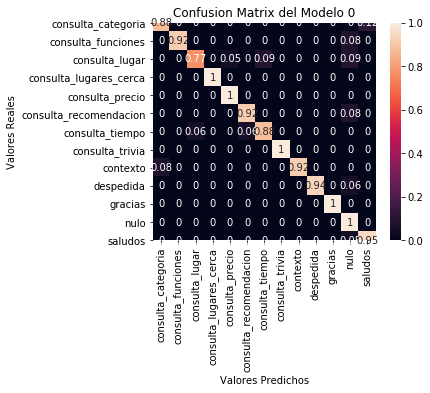

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

i = 0
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_m[i], annot=True)
plt.title('Confusion Matrix del Modelo %i'%i)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

Entre los resultados, destaca la tasa de verdaderos positivos del modelo $M_0$ con la categoría $consulta\_lugar$, con $0.77$. Esto quiere decir, que de todas las oraciones con intención de consultar por la dirección del lugar, la red neuronal solo identifica correctamente el $77\%$

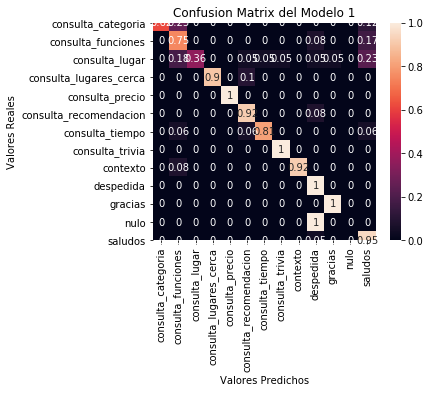

In [39]:
i = 1
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_m[i], annot=True)
plt.title('Confusion Matrix del Modelo %i'%i)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

El Modelo $M_1$ evidencia menores tasas de verdaderos positivos que el anterior. Especialmente en la categoría de 'consulta lugar', donde el recall baja a $0.36$

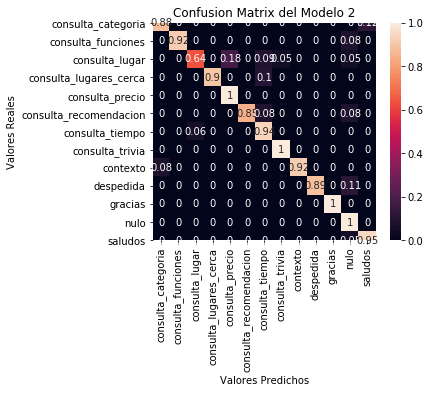

In [40]:
i = 2
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_m[i], annot=True)
plt.title('Confusion Matrix del Modelo %i'%i)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

Igual que en los modelos anteriores, el recall de 'consulta_lugar' es el más bajo.

### Curva ROC

A partir de las métricas $TPR$ (*True positive rate*, o *tasa de verdaderos positivos*) y $FPR$ (*Tasa de falsos positivos*), se puede construir una curva ROC.

* $TPR = \frac{Verdaderos\ Positivos}{Verdaderos\ Positivos + Falsos\ Negativos}$
* $FPR = \frac{Falsos\ Positivos}{Falsos\ Positivos + Verdaderos\ Positivos}$

Entonces, podemos calcular puntualmente estas métricas por categoría:

In [41]:
# Matriz es:
# ............Pred F ......... | ... Pred T
# Real F  Verdaderos Negativos | Falsos Positivos
# Real T  Falsos Negativos     | Verdaderos Positivos
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

metricas_names = ['tag', 'TPR', 'FPR', 'Precision', 'Recall', 'Accuracy']

def get_df_metricas(mcm):
    """
    mcm: Multilabel Confussion Matrix de un modelo
    """
    metricas = []
    for i, m in enumerate(mcm):
        TP = m[1][1] # True Positive
        TN = m[0][0] # True Negatives
        FN = m[1][0] # False Negatives
        FP = m[0][1] # False Positives
        tpr = TP / (TP + FN)
        fpr = FP / (FP + TP)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        metricas.append([tags[i], round(tpr,5),round(fpr,5), round(precision,5), round(recall,5), accuracy])
    metricas = np.array(metricas)    
    return pd.DataFrame(metricas, columns=metricas_names)

i = 0
print("Métricas del Modelo %s"%i)
get_df_metricas(mcm_m[i])

Métricas del Modelo 0


,tag,TPR,FPR,Precision,Recall,Accuracy
0,consulta_categoria,0.875,0.125,0.875,0.875,0.9885057471264368
1,consulta_funciones,0.91667,0.0,1.0,0.91667,0.9942528735632183
2,consulta_lugar,0.77273,0.05556,0.94444,0.77273,0.9655172413793104
3,consulta_lugares_cerca,1.0,0.0,1.0,1.0,1.0
4,consulta_precio,1.0,0.07143,0.92857,1.0,0.9942528735632183
5,consulta_recomendacion,0.92308,0.07692,0.92308,0.92308,0.9885057471264368
6,consulta_tiempo,0.875,0.125,0.875,0.875,0.9770114942528736
7,consulta_trivia,1.0,0.0,1.0,1.0,1.0
8,contexto,0.92308,0.0,1.0,0.92308,0.9942528735632183
9,despedida,0.94444,0.0,1.0,0.94444,0.9942528735632183


In [42]:
i = 1
print("Métricas del Modelo %s"%i)
get_df_metricas(mcm_m[i])

Métricas del Modelo 1


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars


,tag,TPR,FPR,Precision,Recall,Accuracy
0,consulta_categoria,0.625,0.0,1.0,0.625,0.9827586206896551
1,consulta_funciones,0.75,0.47059,0.52941,0.75,0.9367816091954023
2,consulta_lugar,0.36364,0.0,1.0,0.36364,0.9195402298850575
3,consulta_lugares_cerca,0.9,0.0,1.0,0.9,0.9942528735632183
4,consulta_precio,1.0,0.0,1.0,1.0,1.0
5,consulta_recomendacion,0.92308,0.2,0.8,0.92308,0.9770114942528736
6,consulta_tiempo,0.8125,0.07143,0.92857,0.8125,0.9770114942528736
7,consulta_trivia,1.0,0.0625,0.9375,1.0,0.9942528735632183
8,contexto,0.92308,0.0,1.0,0.92308,0.9942528735632183
9,despedida,1.0,0.28,0.72,1.0,0.9597701149425287


In [43]:
i = 2
print("Métricas del Modelo %s"%i)
get_df_metricas(mcm_m[i])

Métricas del Modelo 2


,tag,TPR,FPR,Precision,Recall,Accuracy
0,consulta_categoria,0.875,0.125,0.875,0.875,0.9885057471264368
1,consulta_funciones,0.91667,0.0,1.0,0.91667,0.9942528735632183
2,consulta_lugar,0.63636,0.06667,0.93333,0.63636,0.9482758620689655
3,consulta_lugares_cerca,0.9,0.0,1.0,0.9,0.9942528735632183
4,consulta_precio,1.0,0.23529,0.76471,1.0,0.9770114942528736
5,consulta_recomendacion,0.84615,0.0,1.0,0.84615,0.9885057471264368
6,consulta_tiempo,0.9375,0.21053,0.78947,0.9375,0.9712643678160919
7,consulta_trivia,1.0,0.0625,0.9375,1.0,0.9942528735632183
8,contexto,0.92308,0.0,1.0,0.92308,0.9942528735632183
9,despedida,0.88889,0.0,1.0,0.88889,0.9885057471264368


In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def make_aux_roc(y_pred_tags, y_pred_prob):
    roc_aux = []
    for tag in tags:
        aux_y_test = [1 if y == tag else 0 for y in Y_test_tagged]
        aux_y_pred = [1 if y == tag else 0 for y in y_pred_tags]
        for i in range(len(aux_y_pred)):
            if aux_y_pred[i] == 1:
                aux_y_pred[i] = y_pred_prob[i]
            else:
                aux_y_pred[i] = (1 - y_pred_prob[i])
        false_positive_rate, true_positive_rate, thresholds = roc_curve(aux_y_test, aux_y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        roc_aux.append([false_positive_rate, true_positive_rate, roc_auc])
    return roc_aux

aux_roc_m = []
for i in range(len(models)):
    y_pred_tags = y_p_tag_m[i]
    y_pred_proba = y_p_proba_m[i]
    aux_roc_m.append(make_aux_roc(y_pred_tags, y_pred_proba))

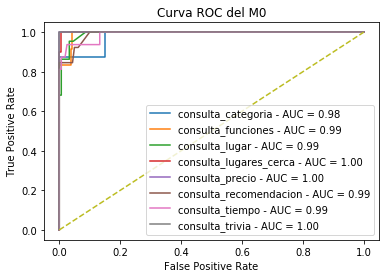

In [49]:
def show_ROC(roc_aux, titulo):
    plt.title(titulo)
    for i, aux in enumerate(roc_aux[:8]):
        plt.plot(aux[0], aux[1], label = "%s - AUC = %0.2f"%(tags[i], aux[2]))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return

show_ROC(aux_roc_m[0], "Curva ROC del M0")

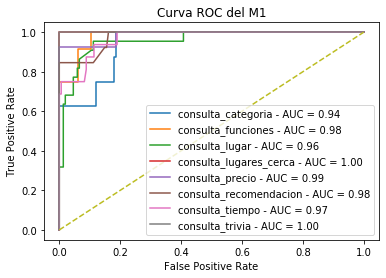

In [50]:
show_ROC(aux_roc_m[1], "Curva ROC del M1")

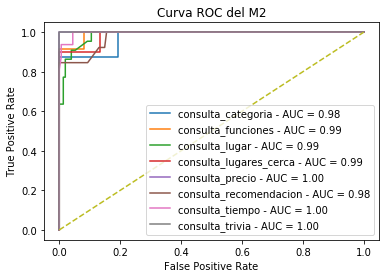

In [51]:
show_ROC(aux_roc_m[2], "Curva ROC del M2")

Entre los 3 modelos, $M_0$ muestra mejores resultados en el AUC, mientras $M_2$ queda en segundo lugar.

## Guardar el modelo elegido:

In [52]:
models[0].save('chatbot_model.model')
print("Red Neuronal Guardada")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: chatbot_model.model\assets
Red Neuronal Guardada
